<a href="https://colab.research.google.com/github/ivychung/plant-ML/blob/final-updates/Epoch_AlexNet_10_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================================
# File Name : Working_AlexNet_10_classes.ipynb
#
# Creation Date : Feburary 22, 2022
#
# Created By : Ivy Chung and Anoushka Gupta
# ========================================

"""Initializing required libraries"""

# so that we can mount google drive
from google.colab import drive

# numerical computation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc # garbage collector to free objects on demand

# file manipulation
import zipfile
import os
import shutil

# load and show an image with Pillow
from PIL import Image

# load and display an image with Matplotlib
%matplotlib inline
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray

# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold

# tensorflow tools
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# other
import cv2

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract the dataset zip file
dataset_name = 'Tomato Disease Dataset New'

drive_dataset_address = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/dataset/'
working_dataset_address = os.path.join('/tmp/', dataset_name)
train_dataset_address = os.path.join(working_dataset_address, 'train')
valid_dataset_address = os.path.join(working_dataset_address, 'valid')

zip_ref = zipfile.ZipFile(drive_dataset_address + dataset_name + '.zip', 'r')
zip_ref.extractall('/tmp/') # Extracts the files into the appropriate folder
zip_ref.close()

In [ ]:
# Removes the __MACOSX file that comes with zipping a file on Mac
try:
  shutil.rmtree('/tmp/__MACOSX')
except:
  pass

In [ ]:
# Getting class names

# Function to extract all sub- file/directory names
def read_filenames(dir_path, file_bool = True):
  if file_bool: # list all files in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isfile(os.path.join(dir_path, f))]
  if not file_bool: # list all subfolders in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isdir(os.path.join(dir_path, f))]

classes = read_filenames(train_dataset_address,file_bool = False)
# classes

In [ ]:
classes = ['Tomato___Bacterial_spot',
  'Tomato___healthy',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Leaf_Mold',
 'Tomato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Early_blight',
 'Tomato___Target_Spot']

# global variables to keep track of how many classes we have
CLASS_SIZE = len(classes)

In [ ]:
# Collect all image names
train_img_names = [read_filenames(os.path.join(train_dataset_address, classes[i])) for i in range(CLASS_SIZE)]
valid_img_names = [read_filenames(os.path.join(valid_dataset_address, classes[i])) for i in range(CLASS_SIZE)]

# Row length should be the number of classes
print("Row Length", len(train_img_names))


# collect each column length
train_row_lengths = []
valid_row_lengths = []

for i in range(CLASS_SIZE):
  train_row_lengths.append(len(train_img_names[i]))
  valid_row_lengths.append(len(valid_img_names[i]))

print("Train column length", train_row_lengths)
print("Valid column length", valid_row_lengths)

Row Length 10
Train column length [1702, 1931, 1741, 1745, 1882, 1851, 1790, 1961, 1920, 1827]
Valid column length [425, 481, 435, 436, 470, 463, 448, 490, 480, 457]


Original image details
JPEG
(256, 256)
RGB

Image in pixel values
<class 'numpy.ndarray'>
(256, 256, 3) 



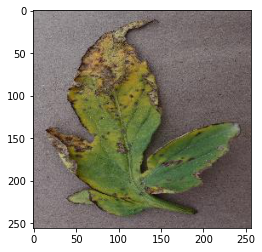


Tomato___Bacterial_spot


In [ ]:
# checking image processing with one image
img_path = os.path.join(train_dataset_address, classes[0], train_img_names[0][1])

# reading the image
image = Image.open(img_path)

# summarize original image details
print("Original image details")
print(image.format)
print(image.size)
print(image.mode)

# convert image to numpy array of pixel values
data = asarray(image)

# summarize converted image details
print("\nImage in pixel values")
print(type(data))
print(data.shape, "\n")

plt.imshow(data)
plt.show()
print("\n" + classes[0])

In [ ]:
# making np array of the images in pixel values
x_train = []
y_train = []
x_test = []
y_test = []

# read the images into an array 
for i in range(CLASS_SIZE):
  for j in range(len(train_img_names[i])):
    img_path = os.path.join(train_dataset_address, classes[i], train_img_names[i][j])
    try:
      img = Image.open(img_path)
      # if images are not the same size, we would need to resize them here
      data = asarray(img) # convert image to numpy array
      x_train.append(data)
      y_train.append(classes[i])
    except:
      pass
  for k in range(len(valid_img_names[i])):
    img_path = os.path.join(valid_dataset_address, classes[i], valid_img_names[i][k])
    try:
      img = Image.open(img_path)
      # if images are not the same size, we would need to resize them here
      data = asarray(img) # convert image to numpy array
      x_test.append(data)
      y_test.append(classes[i])
    except:
      pass


print("Total training image count:", len(x_train))
print("Total test image count:", len(x_test))
print("Total y training image count:", len(y_train))
print("Total y test image count:", len(y_test))
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train).ravel()
y_test = np.asarray(y_test).ravel()

Total training image count: 18349
Total test image count: 4585
Total y training image count: 18349
Total y test image count: 4585


In [ ]:
# convert our data vectors to the desired format
# Our x data vectors are four-dimensional, just as we wanted

# convert the labels be to int-encoded 
label_encoder = LabelEncoder()

# function to convert y data vectors int encoded class matrices
def convert_to_categorical(y_train, y_test, oneHot = True, makeArray = False):
  y_train = label_encoder.fit_transform(y_train)
  y_test = label_encoder.fit_transform(y_test)
  
  if oneHot:
    y_train = keras.utils.to_categorical(y_train, CLASS_SIZE)
    y_test = keras.utils.to_categorical(y_test, CLASS_SIZE)

  if makeArray:
    y_train = np.array([np.array([y]) for y in y_train])
    y_test = np.array([np.array([y]) for y in y_test])
  
  return y_train, y_test

# convert the label formatting
y_train, y_test = convert_to_categorical(y_train, y_test, False, True)

In [ ]:
print(type(y_train), type(y_train[0]))

# check our final shape
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
x_train shape: (18349, 256, 256, 3)
x_test shape: (4585, 256, 256, 3)
y_train shape: (18349, 1)
y_test shape: (4585, 1)


In [ ]:
# takes the train, test, and validation dataset partitions and returns a corresponding TensorFlow Dataset representation
train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test))

# input pipeline
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:', train_ds_size)
print('Test size:', test_ds_size)

Train size: 18349
Test size: 4585


In [ ]:
def create_model():
  AlexNet_model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  

  ])
  return AlexNet_model

In [ ]:
# function to preprocess image
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

# use callback to find the optimal number of epochs to use
earlystopping = EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

Batch Size: 4
--
Epoch 1/100
4587/4587 [==============================] - 39s 8ms/step - loss: 1.2898 - accuracy: 0.5418 - val_loss: 1.3421 - val_accuracy: 0.5148
Epoch 2/100
4587/4587 [==============================] - 36s 8ms/step - loss: 0.9149 - accuracy: 0.6904 - val_loss: 1.0428 - val_accuracy: 0.6082
Epoch 3/100
4587/4587 [==============================] - 36s 8ms/step - loss: 0.7682 - accuracy: 0.7370 - val_loss: 0.8605 - val_accuracy: 0.6784
Epoch 4/100
4587/4587 [==============================] - 36s 8ms/step - loss: 0.6800 - accuracy: 0.7734 - val_loss: 0.7446 - val_accuracy: 0.7236
Epoch 5/100
4587/4587 [==============================] - 37s 8ms/step - loss: 0.5881 - accuracy: 0.8026 - val_loss: 0.6357 - val_accuracy: 0.7574
Epoch 6/100
4587/4587 [==============================] - 36s 8ms/step - loss: 0.5289 - accuracy: 0.8268 - val_loss: 0.6578 - val_accuracy: 0.7537
Epoch 7/100
4587/4587 [==============================] - 36s 7ms/step - loss: 0.4825 - accuracy: 0.8415 - v

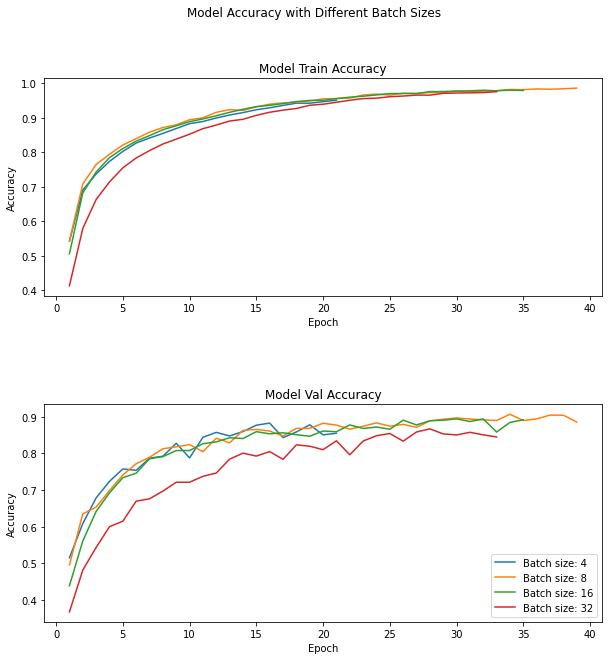

In [ ]:
batch_size = [4, 8, 16, 32]
history = [None] * len(batch_size)

# Run optimal amount of epochs for different batch sizes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(10,10))

fig.subplots_adjust(hspace=0.5) # make a little extra space between the subplots
fig.suptitle('Model Accuracy with Different Batch Sizes')

ax1.set_title('Model Train Accuracy')
ax1.set(xlabel="Epoch", ylabel="Accuracy")

ax2.set_title('Model Val Accuracy')
ax2.set(xlabel="Epoch", ylabel="Accuracy")

for i in range(len(batch_size)):
  AlexNet_model = create_model()
  AlexNet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']    
    )

  print("Batch Size:", batch_size[i])
  print("--")

  train_ds_sized=(train_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=batch_size[i],drop_remainder=True)
         )
  test_ds_sized=(test_ds
        .map(process_image)
        .shuffle(buffer_size=test_ds_size)
        .batch(batch_size=batch_size[i],drop_remainder=True)
        )

  history[i] = AlexNet_model.fit(
    train_ds_sized,
    epochs = 100,
    validation_data = test_ds_sized,
    validation_freq = 1,
    callbacks =[earlystopping]
  )
  print("----------------------------------------------------------------")
  epoch_count = len(history[i].history['loss'])
  ax1.plot(np.linspace(1, epoch_count, epoch_count), history[i].history['accuracy'], label='Batch size: ' + str(batch_size[i]))
  ax2.plot(np.linspace(1, epoch_count, epoch_count), history[i].history['val_accuracy'], label='Batch size: ' + str(batch_size[i]))
  print('Test accuracy Score = ',np.max(history[i].history['val_accuracy']))
  print("----------------------------------------------------------------")
  plt.legend()

plt.show()

In [ ]:
AlexNet_model.history.history.keys()

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(AlexNet_model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(AlexNet_model.history.history['val_loss'],color='r',label='Validation Loss')
ax[0].title.set_text('Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(AlexNet_model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(AlexNet_model.history.history['val_accuracy'],color='r',label='Validation Accuracy')
ax[1].title.set_text('Accuracy')

ax[0].legend()
ax[1].legend()


In [ ]:
print("Evaluate loaded model")
results = AlexNet_model.evaluate(test_ds_sized)
print("test loss", results[0])
print("test accuracy", results[1])

In [ ]:
# testing saving trained model 
base_save_path = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/'
save_path = base_save_path+'Tomato 10 Classes AlexNet Testing/'
AlexNet_model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/Tomato 10 Classes AlexNet Testing/assets


In [ ]:
# testing loading model
AlexNet_model = keras.models.load_model(save_path)

Generate predictions for sample


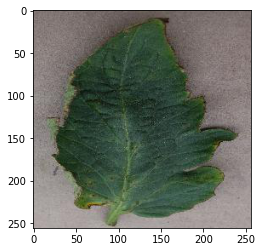

Prediction: Tomato___Bacterial_spot
Actual: Tomato___Bacterial_spot


In [ ]:
print("Generate predictions for sample")

i = randint(0, len(x_test))
# original image
print("Original Image")
plt.imshow(x_test[i])
plt.show()

# standardizing and processing image
print("\nStandardized Image")
image, lbl = process_image(x_test[i], 1)
plt.imshow(image)
plt.show()
image = tf.expand_dims(image, axis=0)

# making the prediction
y_pred = AlexNet_model.predict(image)
prediction = y_pred.argmax()
actual = y_test[i]

print('Prediction:', classes[prediction])
print('Actual:', classes[actual[0]])